In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install mediapipe

In [ ]:
import os 

path_list = []
# G:\MINOR\Shot-net Dataset
data_path = '/content/drive/MyDrive/Shot-net Dataset'
classes_list = sorted(os.listdir(data_path))
for cls in classes_list:
    path_list.append(f"{data_path}/{cls}")

In [ ]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def create_features(image_path, target):

    data = [] # List to add columns
    idx = 0 # Index
    mpPose = mp.solutions.pose
    pose = mpPose.Pose()
    mpDraw = mp.solutions.drawing_utils # For drawing keypoints
    points = mpPose.PoseLandmark # Landmarks
  
    for p in points:
        body_part = str(p)[13:] # For extracting name of the body part
        data.append(body_part + "_x") # X co-ordinate
        data.append(body_part + "_y") # Y co-ordinate
        data.append(body_part + "_z") # Z co-ordinate
        data.append(body_part + "_vis") # Visibility
    data.append('target') # Target
    data = pd.DataFrame(columns = data) # DataFrame with only columns (empty)

    for img in os.listdir(image_path):
        temp = []
        img = cv2.imread(image_path + "/" + img)
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV = BGR, Mediapipe = RGB
        results = pose.process(imgRGB) # Pose detection

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            for p in landmarks:
                temp = temp + [p.x, p.y, p.z, p.visibility] # Append x, y, z, vis of each part
            temp.append(target)
            data.loc[idx] = temp
            idx += 1
    data.to_csv(f"dataset{target}.csv", index=False) # save the data as a csv file

In [ ]:
# Create Features for all classes

for idx, cls in enumerate(path_list):
    create_features(path_list[idx], idx)

In [ ]:
df_list = []

# Store the dataframe of each classes in a list
for idx, cls in enumerate(classes_list):
  df_list.append(pd.read_csv(f'dataset{idx}.csv'))

df = pd.concat(df_list)
df.to_csv('shots_data.csv', index=False)

data = pd.read_csv('shots_data.csv')

In [ ]:
# Remove the df of each classes

for idx, cls in enumerate(classes_list):
  os.remove(f'dataset{idx}.csv')

In [ ]:
# Take features having correlation greater than threshold

cor = df.corr()
threshold = 0.2
target_corr = abs(cor["target"])
features_list = list(target_corr[target_corr>threshold].index)
features_list.remove('target')

body_part = df.columns
idx_features = [i for i in range(len(body_part)) if body_part[i] in features_list]

In [ ]:
cor['target'].sample(10)

LEFT_EYE_vis         -0.081931
LEFT_EAR_y            0.146181
RIGHT_ELBOW_z        -0.426689
LEFT_EYE_INNER_vis   -0.097750
NOSE_y                0.164257
RIGHT_EYE_INNER_x    -0.251475
RIGHT_INDEX_x         0.188473
RIGHT_EYE_INNER_z    -0.432082
LEFT_WRIST_x          0.151224
LEFT_ANKLE_z          0.097799
Name: target, dtype: float64

In [ ]:
data.target = data.target.astype('int') # Converting the float datatype to int
data.target.value_counts()

4    559
5    509
2    475
1    461
0    447
3    411
Name: target, dtype: int64

In [ ]:
data

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,LEFT_EYE_vis,LEFT_EYE_OUTER_x,LEFT_EYE_OUTER_y,LEFT_EYE_OUTER_z,LEFT_EYE_OUTER_vis,RIGHT_EYE_INNER_x,RIGHT_EYE_INNER_y,RIGHT_EYE_INNER_z,RIGHT_EYE_INNER_vis,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,RIGHT_EYE_vis,RIGHT_EYE_OUTER_x,RIGHT_EYE_OUTER_y,RIGHT_EYE_OUTER_z,RIGHT_EYE_OUTER_vis,LEFT_EAR_x,LEFT_EAR_y,LEFT_EAR_z,LEFT_EAR_vis,RIGHT_EAR_x,RIGHT_EAR_y,RIGHT_EAR_z,RIGHT_EAR_vis,MOUTH_LEFT_x,MOUTH_LEFT_y,MOUTH_LEFT_z,MOUTH_LEFT_vis,...,LEFT_HIP_y,LEFT_HIP_z,LEFT_HIP_vis,RIGHT_HIP_x,RIGHT_HIP_y,RIGHT_HIP_z,RIGHT_HIP_vis,LEFT_KNEE_x,LEFT_KNEE_y,LEFT_KNEE_z,LEFT_KNEE_vis,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,RIGHT_KNEE_vis,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,LEFT_ANKLE_vis,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z,RIGHT_ANKLE_vis,LEFT_HEEL_x,LEFT_HEEL_y,LEFT_HEEL_z,LEFT_HEEL_vis,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis,target
0,0.830450,0.833832,-0.053076,0.998836,0.817762,0.844470,-0.096186,0.999057,0.816239,0.844121,-0.095948,0.998944,0.814782,0.843698,-0.095835,0.998975,0.816369,0.844678,-0.044219,0.998683,0.813118,0.844453,-0.043936,0.998374,0.809842,0.844279,-0.043738,0.998811,0.794514,0.830901,-0.199314,0.999213,0.786659,0.832971,0.037718,0.999241,0.826222,0.819550,-0.081727,0.998448,...,0.516413,-0.172015,0.998694,0.674424,0.505647,0.171892,0.998628,0.821452,0.540761,-0.114162,0.854030,0.741048,0.439667,0.302655,0.461119,0.817963,0.667815,0.111618,0.491765,0.760369,0.442941,0.370496,0.422621,0.816791,0.669308,0.134176,0.538842,0.756472,0.439229,0.375029,0.433507,0.830610,0.750792,0.152049,0.536885,0.778751,0.465422,0.347000,0.519694,0
1,0.782654,0.799939,-0.166235,0.997595,0.766684,0.798882,-0.164054,0.997885,0.763222,0.795105,-0.164152,0.997815,0.759761,0.791220,-0.164381,0.997702,0.776165,0.804978,-0.148590,0.997411,0.779740,0.805400,-0.148622,0.996969,0.783121,0.805803,-0.148789,0.997590,0.762474,0.767175,-0.133477,0.997298,0.793341,0.787001,-0.053635,0.997448,0.788719,0.780611,-0.150582,0.995084,...,0.405898,-0.111484,0.998782,0.724965,0.408901,0.111352,0.998731,0.515738,0.310008,-0.187537,0.868055,0.634116,0.322910,0.294243,0.494758,0.417975,0.444661,-0.088474,0.539918,0.562541,0.305408,0.409197,0.471035,0.416088,0.482765,-0.067360,0.582002,0.548880,0.313927,0.422435,0.479430,0.338233,0.416021,-0.032588,0.579907,0.530588,0.248073,0.428013,0.554603,0
2,0.743410,0.744364,-0.351658,0.997786,0.734523,0.748967,-0.390113,0.998021,0.736269,0.747021,-0.390186,0.997979,0.737963,0.744998,-0.390408,0.997866,0.730089,0.751263,-0.368600,0.997586,0.728847,0.750827,-0.368566,0.997200,0.727486,0.750460,-0.368692,0.997752,0.751203,0.722070,-0.466625,0.997495,0.731759,0.728830,-0.363908,0.997647,0.757943,0.726558,-0.364467,0.995522,...,0.392003,-0.128187,0.998902,0.748693,0.419894,0.128594,0.998856,0.761688,0.229619,-0.250275,0.881039,0.642273,0.298545,0.391071,0.538621,0.645464,0.491204,-0.195932,0.585442,0.585978,0.290462,0.594380,0.522754,0.643526,0.523530,-0.185140,0.623252,0.580817,0.297302,0.612803,0.529819,0.584564,0.523991,-0.180874,0.621422,0.568520,0.245222,0.606082,0.597366,0
3,0.860915,0.461075,-1.368510,0.997924,0.848542,0.430726,-1.377788,0.998156,0.850142,0.431669,-1.377737,0.998111,0.881769,0.462001,-1.378128,0.998036,0.841184,0.420512,-1.394563,0.997777,0.838875,0.420556,-1.394629,0.997405,0.835893,0.417699,-1.394913,0.997909,0.833423,0.438477,-1.229830,0.997689,0.816002,0.419221,-1.310796,0.997726,0.829049,0.471713,-1.294387,0.995925,...,0.364413,0.075139,0.998882,0.678901,0.322049,-0.074276,0.998929,0.655896,0.380430,0.338182,0.825893,0.569081,0.261483,0.254087,0.576783,0.539971,0.459460,0.779415,0.562121,0.429144,0.204432,0.622983,0.560040,0.523342,0.471593,0.826475,0.612492,0.414713,0.204886,0.659558,0.564281,0.523625,0.46

In [ ]:
print(classes_list)

['0. Cut Shot', '1. Cover Drive', '2. Straight Drive', '3. Pull Shot', '4. Leg Glance Shot', '5. Scoop Shot']


In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = data.loc[:, features_list], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel = 'linear', C=30, max_iter=2000)
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(C=30, kernel='linear', max_iter=2000)

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        93
           1       0.91      0.91      0.91        92
           2       0.90      0.90      0.90        96
           3       0.94      0.96      0.95        82
           4       0.91      0.87      0.89       108
           5       0.93      0.95      0.94       102

    accuracy                           0.92       573
   macro avg       0.92      0.92      0.92       573
weighted avg       0.92      0.92      0.92       573



In [ ]:
# For terminal, direct train

import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import sys

from warnings import filterwarnings
filterwarnings('ignore')

data_path = '/content/shots_data.csv'
data = pd.read_csv(data_path)

cor = data.corr()
threshold = 0.2
target_corr = abs(cor["target"])
features_list = list(target_corr[target_corr>threshold].index)
features_list.remove('target')

X, y = data.loc[:, features_list], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel = 'linear', C=30, max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Model Trained!")
print(classification_report(y_test, y_pred))


Model Trained!
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92        93
         1.0       0.91      0.91      0.91        92
         2.0       0.90      0.90      0.90        96
         3.0       0.94      0.96      0.95        82
         4.0       0.91      0.87      0.89       108
         5.0       0.93      0.95      0.94       102

    accuracy                           0.92       573
   macro avg       0.92      0.92      0.92       573
weighted avg       0.92      0.92      0.92       573



In [ ]:
# # Save the trained model

# import pickle

# pkl_filename = "shot_classification.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

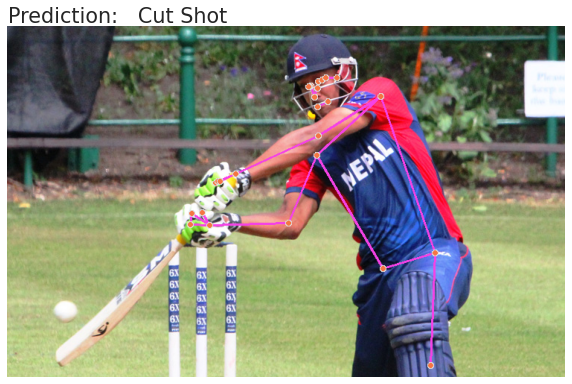

In [ ]:
# # Load the model and predict shots

# import pickle
# import re

# pkl_filename = '/content/shot_classification.pkl'
# with open(pkl_filename, 'rb') as file:
#     model = pickle.load(file)

# pickle_model = model

df = pd.read_csv('/content/shots_data.csv')
cor = df.corr()
threshold = 0.2
target_corr = abs(cor["target"])
features_list = list(target_corr[target_corr>threshold].index)
features_list.remove('target')

body_part = df.columns
idx_features = [i for i in range(len(body_part)) if body_part[i] in features_list]

def predict_shot(path):

    mpPose = mp.solutions.pose
    pose = mpPose.Pose()
    mpDraw = mp.solutions.drawing_utils # For drawing keypoints
    points = mpPose.PoseLandmark # Landmarks

    data = []
    img = cv2.imread(path)
    imageWidth, imageHeight = img.shape[:2]
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)

    # Run this only when landmarks are detected
    if results.pose_landmarks:
        mpDraw.draw_landmarks(imgRGB, results.pose_landmarks, mpPose.POSE_CONNECTIONS,
                                mpDraw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                mpDraw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        landmarks = results.pose_landmarks.landmark
        for i,j in zip(points,landmarks):
            data = data + [j.x, j.y, j.z, j.visibility]
    data = [data[i] for i in idx_features]
    result = int(model.predict([data])[0])
    plt.figure(figsize=(10, 10))
    # Remove the text class number
    text = f"Prediction:{re.sub('[^a-zA-Z]', ' ', classes_list[result])}"
    plt.text(0, -5, text, size='xx-large', weight=500)
    plt.imshow(imgRGB)
    plt.grid(False)
    plt.axis(False)
    # plt.savefig("leg glance aasif", bbox_inches='tight') 

path = '/content/test.jpg'
predict_shot(path)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


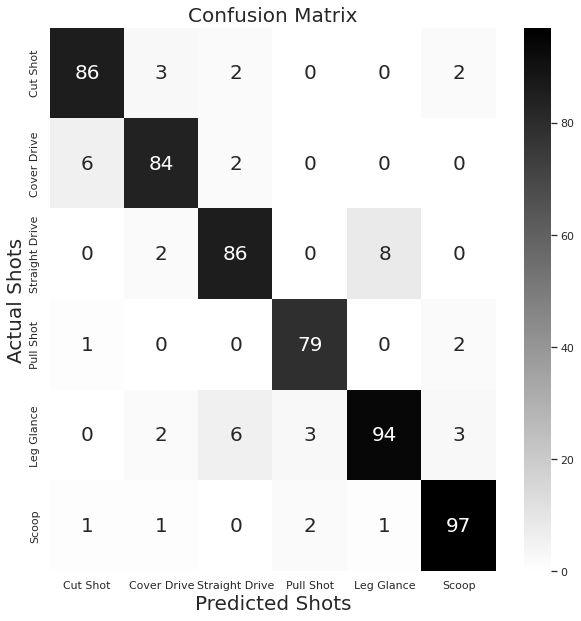

In [ ]:
# Plotting confusion matrix

confuse = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
shots_list = ['Cut Shot', 'Cover Drive', 'Straight Drive', 'Pull Shot', 'Leg Glance', 'Scoop']

annot_size = 20
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.figsize'] = (10, 10)
conf_df = pd.DataFrame(confuse)
conf_df.index = shots_list
conf_df.columns = shots_list
sns.heatmap(conf_df, annot=True, cmap='binary', annot_kws={'size': annot_size})
plt.title('Confusion Matrix',  {'fontsize': annot_size}) 
plt.xlabel('Predicted Shots', {'fontsize': annot_size})
plt.ylabel('Actual Shots', {'fontsize': annot_size})
plt.savefig('Confusion Matrix.png', dpi=200, format='png', bbox_inches='tight')

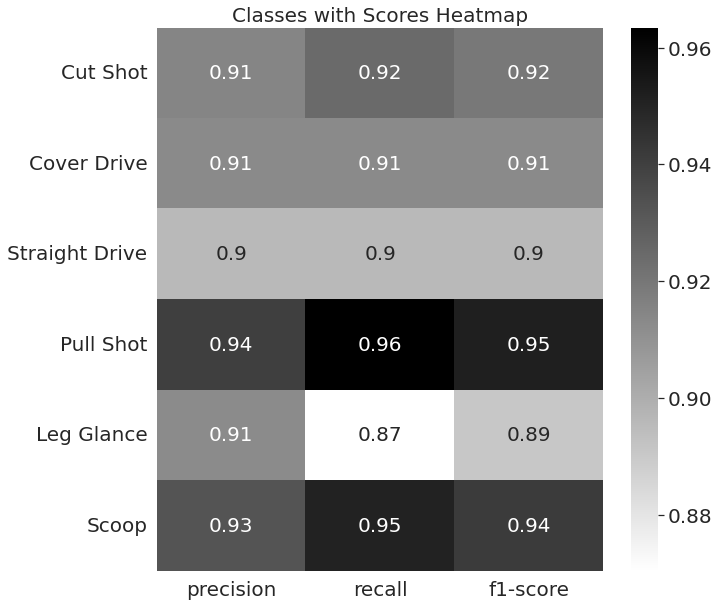

In [ ]:
# Plotting Scores

clf_report = classification_report(y_test, y_pred, output_dict=True)

cls_df = pd.DataFrame(clf_report).iloc[:-1, :-3].T
cls_df.index = shots_list
annot_size = 20
sns.set(rc = {'figure.figsize':(10, 10), 'xtick.labelsize':annot_size, 'ytick.labelsize':annot_size})
sns.heatmap(cls_df, annot=True, annot_kws={'size': annot_size}, cmap="binary")
plt.title('Classes with Scores Heatmap', {'fontsize': annot_size}) 
plt.savefig('Classes with Scores Heatmap.png', dpi=200, format='png', bbox_inches='tight')

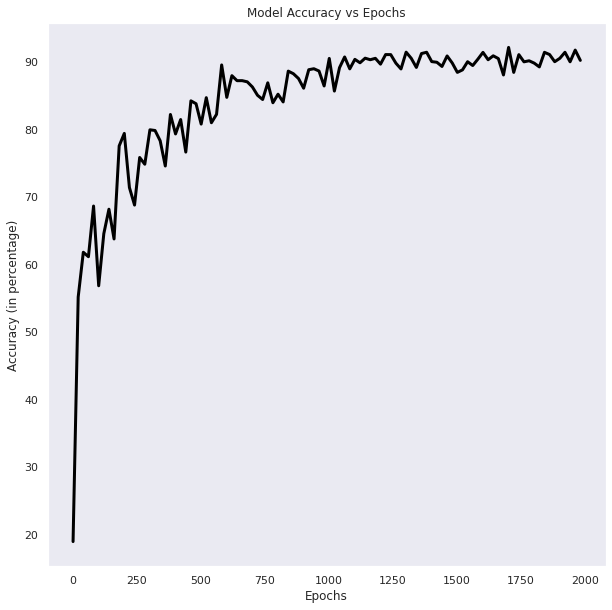

In [ ]:
# Accuracy plot

from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
from sklearn.metrics import f1_score, hinge_loss

f1 = []
iter_list = [i for i in range(1, 2000, 20)]
for iter_val in iter_list:
    model = SVC(kernel = 'linear', C=30, max_iter=iter_val)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1.append(f1_score(y_test, y_pred, average='weighted')*100)

plt.title("Model Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (in percentage)")
sns.lineplot(x=iter_list, y=f1, linewidth=3, color='black')
plt.grid(False)
plt.savefig('Model accuracy.png')
plt.show()

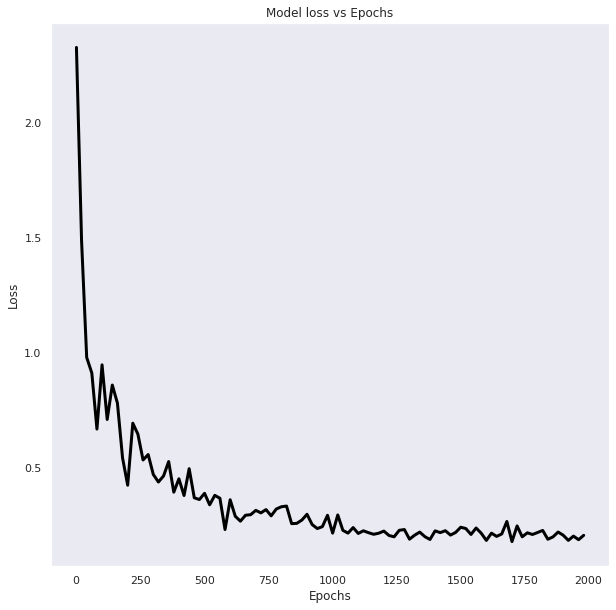

In [ ]:
# Loss plot

loss = []
iter_list = [i for i in range(1, 2000, 20)]
for iter_val in iter_list:
    model = SVC(kernel = 'linear', C=30, max_iter=iter_val)
    model.fit(X_train, y_train)
    y_prob = model.decision_function(X_test)
    loss.append(hinge_loss(y_test, y_prob))

plt.title("Model loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
sns.lineplot(x=iter_list, y=loss, linewidth=3, color='black')
plt.grid(False)
plt.savefig('Model loss.png')
plt.show()

In [ ]:
import re

def predict_shot(path):

    mpPose = mp.solutions.pose
    pose = mpPose.Pose()
    mpDraw = mp.solutions.drawing_utils # For drawing keypoints
    points = mpPose.PoseLandmark # Landmarks

    data = []
    img = cv2.imread(path)
    imageWidth, imageHeight = img.shape[:2]
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)

    # Run this only when landmarks are detected
    if results.pose_landmarks:
        mpDraw.draw_landmarks(imgRGB, results.pose_landmarks, mpPose.POSE_CONNECTIONS,
                                mpDraw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                mpDraw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        landmarks = results.pose_landmarks.landmark
        for i,j in zip(points,landmarks):
            data = data + [j.x, j.y, j.z, j.visibility]
    data = [data[i] for i in idx_features]
    result = model.predict([data])[0]
    plt.figure(figsize=(10, 10))
    # Remove the text class number
    text = f"Prediction:{re.sub('[^a-zA-Z]', ' ', classes_list[result])}"
    plt.text(0, -5, text, size='xx-large', weight=500)
    plt.imshow(imgRGB)
    plt.grid(False)
    plt.axis(False)
    # plt.savefig("leg glance aasif", bbox_inches='tight') 

In [ ]:
path = '/content/bhuwan shot.jpg'
predict_shot(path)

In [ ]:
import random

dir = os.path.join(data_path, '3. Pull Shot')
for idx in random.sample(range(len(dir)), 20):
  file = os.listdir(dir)[idx]
  file_path = os.path.join(dir, file)
  try:
    predict_shot(file_path)
  except:
    pass